***Vorlesung 'Syntax natürlicher Sprachen', WS 2019/20***

---
# Übung 12

In [1]:
from exercises_12 import *
from questions import aufgabe
import nltk
from nltk.corpus import treebank
from nltk.grammar import ProbabilisticProduction, PCFG
from collections import defaultdict

---
## Aufgabe 1: Herunterladen von Ressourcen

#### Laden Sie sich zunächst die Ressource `corpora/treebank` über den NLTK Download-Manager herunter.

In [2]:
# nltk.download()

---
## Aufgabe 2: Grammatikinduktion

#### In dieser Aufgabe soll vollautomatisch aus Daten (Syntaxbäumen) eine probabilistische, kontextfreie Grammatik erzeugt werden.

Veranschaulichen Sie sich das Vorgehen zunächst an einem Beispiel. Gegeben sei folgende Grammatik:

In [2]:
cfg = """
S -> NP VP
VP -> V NP PP
VP -> V NP
NP -> DET N
NP -> NP PP
PP -> P NP

DET -> "the" | "a"
N -> "boy" | "woman" | "telescope"
V -> "saw"
P -> "with"
"""

Sie modelliert sehr einfache Sätze der Form SBJ saw OBJ mit optionaler Präpositionalphrase am Ende. Diese Präpositionalphrase kann entweder der näheren Bestimmung des Objekts oder der näheren Bestimmung der in der Verbalphrase ausgedrückten Handlung dienen.

**Für welche Regeln müssen wir die Wahrscheinlichkeiten berechnen, wenn wir mit statistischen Methoden untersuchen wollen, ob PPs häufiger Teil der VP oder Teil der NP sind?**

Approximieren Sie mittels vergleichbarer Konstruktionen in der Penn Treebank die Wahrscheinlichkeiten für die ersten beiden dieser Regeln.

In [4]:
counter = defaultdict(int)

for tree in treebank.parsed_sents():
    for prod in tree.productions():
        if prod.lhs() == nltk.Nonterminal('VP'):
            counter[prod] += 1

constructions = [ (k, counter[k]) for k in sorted(counter.keys(), key=counter.__getitem__, reverse=True) ]
constructions[:30]

[(VP -> TO VP, 1257),
 (VP -> VB NP, 805),
 (VP -> MD VP, 759),
 (VP -> VBD SBAR, 631),
 (VP -> VBZ VP, 459),
 (VP -> VBD NP, 378),
 (VP -> VBG NP, 375),
 (VP -> VBD VP, 361),
 (VP -> VBP VP, 337),
 (VP -> VBZ NP, 261),
 (VP -> VB VP, 258),
 (VP -> VBN NP, 250),
 (VP -> VP CC VP, 234),
 (VP -> VBD S, 223),
 (VP -> VBZ S, 215),
 (VP -> VBZ SBAR, 197),
 (VP -> VBP NP, 185),
 (VP -> VBN NP PP-CLR, 178),
 (VP -> VBN NP PP, 170),
 (VP -> VBZ NP-PRD, 163),
 (VP -> VB S, 155),
 (VP -> VBN S, 141),
 (VP -> VBP SBAR, 121),
 (VP -> VB PP-CLR, 107),
 (VP -> VBG S, 89),
 (VP -> VBP S, 88),
 (VP -> VB NP PP-CLR, 88),
 (VP -> VBZ ADJP-PRD, 87),
 (VP -> VBN VP, 84),
 (VP -> MD RB VP, 82)]

In [5]:
# Berechnung der Wahrscheinlichkeiten
vp_wo_pp = 805 + 378 + 375 + 261 + 250 + 185 + 163
vp_w_pp = 178 + 170 + 88

vp_total = vp_wo_pp + vp_w_pp
prob_vp_wo_pp = vp_wo_pp / vp_total
prob_vp_w_pp = vp_w_pp / vp_total

prob_vp_w_pp, prob_vp_wo_pp

(0.15282159130739573, 0.8471784086926043)

Im Folgenden wollen wir vollautomatisch eine dem Penn Treebank Schema entsprechende PCFG erzeugen.

#### Füllen Sie die Lücken und versuchen Sie mithilfe Ihrer automatisch erstellten Grammatik die folgenden Sätze zu parsen:

In [11]:
test_sentences = [
    "the men saw a car .",
    "the woman gave the man a book .",
    "she gave a book to the man .",
    "she saw the man with the book ."
]

In [7]:
# Production count: the number of times a given production occurs
pcount = defaultdict(int)

# LHS-count: counts the number of times a given lhs occurs
lcount = defaultdict(int)

for tree in treebank.parsed_sents():
    for prod in tree.productions():
        pcount[prod] += 1
        lcount[prod.lhs()] += 1
        
productions = [
    ProbabilisticProduction(
        p.lhs(), p.rhs(),
        prob=pcount[p] / lcount[p.lhs()]
    )
    for p in pcount
]

start = nltk.Nonterminal('S')
grammar = PCFG(start, productions)
parser = nltk.ViterbiParser(grammar)

In [12]:
for s in test_sentences:
    for t in parser.parse(nltk.word_tokenize(s)):
        print(t.prob())
        t.pretty_print()

2.269940263066198e-15
                S                 
       _________|_______________   
      |             VP          | 
      |          ___|___        |  
    NP-SBJ      |       NP      | 
  ____|_____    |    ___|___    |  
 DT        NNS VBD  DT      NN  . 
 |          |   |   |       |   |  
the        men saw  a      car  . 

8.44395440336237e-21
                       S                             
       ________________|___________________________   
      |                        VP                  | 
      |            ____________|________           |  
    NP-SBJ        |        NP         NP-TMP       | 
  ____|______     |     ___|___     ____|_____     |  
 DT          NN  VBD   DT      NN  DT         NN   . 
 |           |    |    |       |   |          |    |  
the        woman gave the     man  a         book  . 

1.3157826588159793e-18
                     S                         
   __________________|_______________________   
  |                  VP   

---
## Aufgabe 3: Neuronale Netze

### (a) Lineare Zusammenhänge

In dieser Aufgabe sollen Sie die grundlegenden Eigenschaften von Feedforward-Netzen vertiefen.
Falls noch nicht geschehen, installieren Sie dafür die `pytorch`-Bibliothek. Befehle dafür finden Sie [hier](https://pytorch.org/get-started/locally/).

Wenn Sie den Code der heutigen Übung auf Ihrem eigenen Rechner ausführen wollen, sollten Sie anschließend auch `ignite` installieren, das einige zusätzliche Hilfsfunktionen bereitstellt:

Mit pip:
```
pip install pytorch-ignite
```

ODER mit conda:
```
conda install ignite -c pytorch
```

In [13]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline  

Im folgenden wollen wir ein kleines Beispielproblem simulieren. `x` soll unsere Eingabe sein (etwa Merkmalsvektoren) und `y1` repräsentiert die gewünschte Ausgabe (z.B. scores, um Wahrscheinlichkeiten zu berechnen).

In [14]:
x = torch.arange(10, dtype=torch.float).reshape(10,1)
y1 = x/2 + 2*torch.rand_like(x)

Mit der `show`-Funktion können Sie sich die Daten einfach visualisieren.

In [15]:
def show(x, y, model=None, epoch=0):
    model_label = 'model' if epoch < 1 else 'model {}'.format(epoch)

    with torch.no_grad():
        if model:
            plt.plot(x, model(x), label=model_label)

    if epoch < 2:
        plt.scatter(x, y, label='truth')
    
    plt.legend()
    plt.xlabel('features')
    plt.ylabel('outcome')

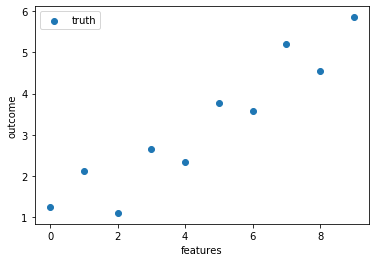

In [16]:
show(x, y1)

1. Wir vermuten einen linearen Zusammenhang zwischen Eingabe und Ausgabe. Definieren Sie daher zunächst ein einfaches neuronales Netz mit nur einer linearen Schicht.

In [17]:
model1 = torch.nn.Linear(1, 1)

In [25]:
model1.parameters()

<generator object Module.parameters at 0x000001697896EE48>

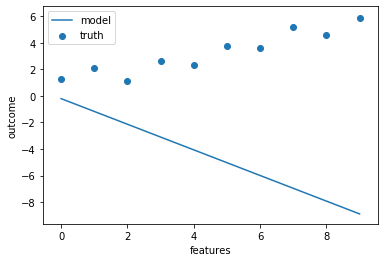

In [18]:
show(x, y1, model=model1)

2. Ein zufällig initialisiertes Modell ist noch nicht optimal. Wir sollten es jetzt trainieren. Initialisieren Sie dafür einen *Stochastic Gradient Descent*-Optimierer mit einer *Learning Rate* von `0.01` und erstellen Sie eine *Loss*-Funktion, die den *Mean Squared Error* berechnet.

In [20]:
from ignite.engine import Events, create_supervised_trainer

opt1 = torch.optim.SGD(model1.parameters(), lr=0.01)
loss = torch.nn.MSELoss()
trainer = create_supervised_trainer(model1, opt1, loss)

In [21]:
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_results(trainer):
    print('Loss at epoch {}: {}'.format(trainer.state.epoch, trainer.state.output))
    show(x, y1, model=model1, epoch=trainer.state.epoch)

Loss at epoch 1: 78.75960540771484
Loss at epoch 2: 14.037429809570312
Loss at epoch 3: 2.8535876274108887
Loss at epoch 4: 0.9191951751708984
Loss at epoch 5: 0.5827876329421997


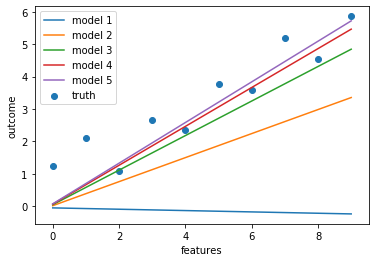

In [22]:
trainer.run([(x, y1)], max_epochs=5)

### (b) Nonlineare Zusammenhänge

Bei gleichem Input sehen unsere Zielwerte auf einmal so aus:

In [26]:
y2 = (x-4)**2 + 10*torch.rand_like(x)

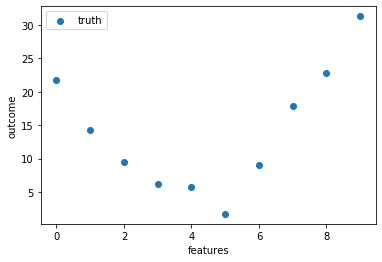

In [27]:
show(x, y2)

Das wird sich mit einer linearen Funktion nicht mehr gut modellieren lassen. Wir fügen daher eine versteckte Schicht (*hidden layer*) zu unserem Modell hinzu. Probieren Sie verschiedene Werte für die Kapazität der versteckten Schicht (*hidden size*); starten Sie dabei mit `10`. Als nicht-lineare Aktivierungsfunktion sollen Sie die aus der Vorlesung bekannte `ReLU`-Funktion nutzen.

In [80]:
model2 = torch.nn.Sequential(
    torch.nn.Linear(1, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 1)
)

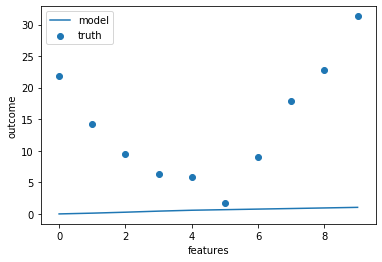

In [67]:
show(x, y2, model=model2)

Wir trainieren wieder unsere zufällig initialisierte Funktion. Testen Sie verschiedene *learning rates* und Optimierer (z.B. `Adam` anstatt `SGD`).

In [81]:
from ignite.engine import Events, create_supervised_trainer

opt2 = torch.optim.Adam(model2.parameters(), lr=0.01)
trainer = create_supervised_trainer(model2, opt2, loss)

In [82]:
trainer.run([(x, y2)], max_epochs=200)

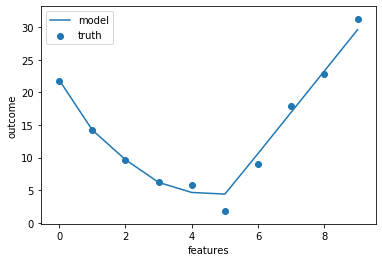

In [83]:
show(x, y2, model=model2)

--- 
# Hausaufgaben

---
## Aufgabe 4: PCFGs und Viterbi

#### Beantworten Sie die folgenden grundlegenden Fragen über die heute verwendeten Technologien.

In [84]:
aufgabe(blatt12_4)

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Welche der folgenden Bedingungen wird an eine…

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Was ist die Aufgabe des Viterbi-Algorithmus?<…

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Warum muss zwischen zwei Schichten eines Feed…

---
## Aufgabe 5: NLTK-Kapitel zu PCFGs

#### In folgenden NLTK-Kapiteln wird das Parsing mit Probabilistischen kontextfreien Grammatiken behandelt:
- Teilkapitel 8.6 (’Grammar Development’): http://www.nltk.org/book/ch08.html
- Teilkapitel 2.12 und 2.13 (’Grammar Induction’ und ’Normal Forms’) des Zusatzkapitels zu Kapitel 8: http://www.nltk.org/book/ch08-extras.html
- (Teilkapitel 2.9-2.11 des Zusatzkapitels zu Kapitel 8 behandelt Probabilistische ’Chart Parsing’-Algorithmen: http://www.nltk.org/book/ch08-extras.html)

#### Beantworten Sie folgende Fragen zu Teilkapitel 8.6.2 (’Pernicious Ambiguity’):

---
### Aufgabe 5 a:

#### Welche zwei Faktoren führen bei der syntaktischen Analyse natürlicher Sprache mittels formaler Grammatiken zu mehr Ambiguität (Anzahl an Ableitungen)?

In [85]:
aufgabe(blatt12_5a)

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Welche zwei Faktoren führen bei der syntaktis…

---
### Aufgabe 5 b:


In [86]:
aufgabe(blatt12_5b)

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Welche zwei Arten von Ambiguität unterscheide…